In [2]:
pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
pip install datasets

In [4]:
# necessary imports
import os
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
import joblib
import seaborn as sns
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from transformers import (
    Trainer,
    TrainingArguments,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    pipeline,
)

In [5]:
# using a gpu if available, reducing resource usage
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [6]:
# loading the emotions classification set from hugging face
emotions = load_dataset("dair-ai/emotion")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [7]:
# checking the labels from the training set
emotions["train"].features["label"]

ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)

In [8]:
# checking the examples from the training set
emotions["train"]["text"]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy',
 'ive been feeling a little burdened lately wasnt sure why that was',
 'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny',
 'i feel as confused about life as a teenager or as jaded as a year old man',
 'i have been with petronas for years i feel that petronas has performed well and made a huge profit',
 'i feel romantic too',
 'i feel like i have to make the suffering i m seeing mean something',
 'i do feel that running is a divine experience and that i can expect to have some type of spiritual encounter',
 'i think it s the easiest time of year to feel dissatisfied',
 'i feel low energy i m just thirst

In [1]:
# baseline model on training data (dair-ai/emotion)

In [9]:
# employing tfidf vectorizer to use for the logistic regression model
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(emotions["train"]["text"])
X_val = vectorizer.transform(emotions["validation"]["text"])

In [10]:
# defining the lr model
model_lr = LogisticRegression(max_iter=1000)
# training lr on the emotions dataset
model_lr.fit(X_train, emotions["train"]["label"])

LogisticRegression(max_iter=1000)

In [11]:
# training lr on the emotions dataset
train_preds = model_lr.predict(X_train)

# checking the scores from the training
train_accuracy = accuracy_score(emotions["train"]["label"], train_preds)
print(f"Training accuracy: {train_accuracy}")
print(classification_report(emotions["train"]["label"], train_preds, target_names=emotions["train"].features["label"].names))

Training accuracy: 0.932
              precision    recall  f1-score   support

     sadness       0.94      0.97      0.96      4666
         joy       0.91      0.98      0.94      5362
        love       0.95      0.79      0.87      1304
       anger       0.95      0.90      0.93      2159
        fear       0.93      0.90      0.91      1937
    surprise       0.95      0.70      0.80       572

    accuracy                           0.93     16000
   macro avg       0.94      0.87      0.90     16000
weighted avg       0.93      0.93      0.93     16000



In [12]:
# validation set predictions and scores
val_preds = model_lr.predict(X_val)
val_accuracy = accuracy_score(emotions["validation"]["label"], val_preds)
print(f"Validation accuracy: {val_accuracy}")
print(classification_report(emotions["validation"]["label"], val_preds, target_names=emotions["train"].features["label"].names))

Validation accuracy: 0.863
              precision    recall  f1-score   support

     sadness       0.86      0.94      0.90       550
         joy       0.85      0.94      0.89       704
        love       0.89      0.63      0.74       178
       anger       0.91      0.82      0.87       275
        fear       0.85      0.75      0.80       212
    surprise       0.84      0.58      0.69        81

    accuracy                           0.86      2000
   macro avg       0.87      0.78      0.81      2000
weighted avg       0.86      0.86      0.86      2000



In [13]:
# saving the trained lr model - just in case
joblib.dump(model_lr, "logistic_regression_emotion.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

In [14]:
# evaluating the lr model on the test set
X_test = vectorizer.transform(emotions["test"]["text"])

test_preds = model_lr.predict(X_test)
# checking the test scores
print(classification_report(emotions["test"]["label"], test_preds, target_names=emotions["train"].features["label"].names))

              precision    recall  f1-score   support

     sadness       0.90      0.93      0.91       581
         joy       0.84      0.96      0.89       695
        love       0.82      0.59      0.69       159
       anger       0.90      0.82      0.86       275
        fear       0.89      0.79      0.84       224
    surprise       0.85      0.52      0.64        66

    accuracy                           0.87      2000
   macro avg       0.87      0.77      0.81      2000
weighted avg       0.87      0.87      0.86      2000



In [15]:
# finetune transformer on dair-ai/emotion

In [16]:
# creating 2 helper dictionaries with the names of the classes
cls_labels = emotions['train'].features['label'].names
idx2lbl = dict(zip(range(6), cls_labels))
lbl2idx = dict(zip(cls_labels, range(6)))
idx2lbl

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

In [17]:
# printing the labels with the idx to check how it looks
rand_idxs = random.sample(range(len(emotions['train'])), 10)

for idx in rand_idxs:
    sample = emotions['train'][idx]
    seq = sample['text']
    lbl = sample['label']
    print(f"Sequence: {seq}\nLabel Index: {lbl}\nLabel: {idx2lbl[lbl]}")

Sequence: i wont face these obstacles and feel like a stressed out mess or worse a mommy failure
Label Index: 0
Label: sadness
Sequence: i just feel very satisfied and content
Label Index: 1
Label: joy
Sequence: ive been desperately trying to finish up my machine learning p set but im now far enough along that im no longer in complete panic mode i feel like my mood is on a spinner is she detachedly amused or freaking the fuck out
Label Index: 1
Label: joy
Sequence: im shocked i feel my own little problems put into perspective and i feel heartache for the innocent lives that have been ended
Label Index: 1
Label: joy
Sequence: i can feel it coming and im determined to see it through
Label Index: 1
Label: joy
Sequence: finding out that i am not an as able student as i thought
Label Index: 4
Label: fear
Sequence: i am feeling very thankful and relieved
Label Index: 1
Label: joy
Sequence: i feel he is talented and good
Label Index: 1
Label: joy
Sequence: i quit my job in financial services 

In [18]:
# using a pre-trained tokenizer from hugging face, specifically for distilbert
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [19]:
# checking the output of the tokenizer
example = emotions["train"]["text"][1234]
print(example)
tokenizer(example)

i guess you cant see how wed feel a bit unwelcome


{'input_ids': [101, 1045, 3984, 2017, 2064, 2102, 2156, 2129, 21981, 2514, 1037, 2978, 4895, 8545, 22499, 4168, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [20]:
# in case theres too many tokens for bert - context size is 512
def tokenize_seqs(examples):
  return tokenizer(examples["text"], truncation = True, max_length=512)

emotions = emotions.map(tokenize_seqs, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [21]:
# renaming the label column because hugging face trainer expects the column to be called "labels"
emotions = emotions.rename_column("label","labels")

In [22]:
# defining the distilbert model
model_tb = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=6, id2label=idx2lbl, label2id=lbl2idx)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# function for displaying metrics later on
def compute_metrics(eval_preds):
  preds = eval_preds.predictions.argmax(-1)
  lbls = eval_preds.label_ids
  f1 = f1_score(lbls, preds, average="weighted")
  return {"f1" : f1}

In [24]:
# using some researched tricks to make training more efficient - some described in the report
training_args = TrainingArguments(
    output_dir='./logs/run1/',
    per_device_train_batch_size = 32,
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2,
    learning_rate=2e-5,
    weight_decay=1e-3,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    logging_strategy="steps",
    logging_steps = len(emotions["train"]) / 32,
    save_strategy="epoch",
    save_total_limit=1,
    seed = 42,
    data_seed = 42,
    fp16=True,
    dataloader_num_workers=2,
    load_best_model_at_end=True
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [25]:
# preparing the trainer from hugging face to start training
trainer = Trainer(
    model=model_tb,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions["train"],
    eval_dataset=emotions["validation"],
    tokenizer=tokenizer
)

<ipython-input-25-3e698c21dceb>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [26]:
# training
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,F1
1,No log,0.283015,0.917716
2,0.994600,0.186864,0.932677
3,0.994600,0.174239,0.930250


TrainOutput(global_step=750, training_loss=0.7623164876302083, metrics={'train_runtime': 133.9668, 'train_samples_per_second': 358.298, 'train_steps_per_second': 5.598, 'total_flos': 647803507542912.0, 'train_loss': 0.7623164876302083, 'epoch': 3.0})

In [27]:
# saving the model and the tokenizer just in case
trainer.save_model("./logs/run1/")
tokenizer.save_pretrained("./logs/run1/")

('./logs/run1/tokenizer_config.json',
 './logs/run1/special_tokens_map.json',
 './logs/run1/vocab.txt',
 './logs/run1/added_tokens.json',
 './logs/run1/tokenizer.json')

In [28]:
# analyse results

In [29]:
# distilbert test score
test_predictions = trainer.predict(test_dataset=emotions['test'])

print(f"Test set F1 score: {test_predictions.metrics['test_f1']:.4f}")

Test set F1 score: 0.9210


In [30]:
# full report for distilbert per class in testing
predictions = test_predictions.predictions.argmax(axis=-1)
print("Classification report:")
print(classification_report(emotions['test']['labels'], predictions))

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       581
           1       0.94      0.94      0.94       695
           2       0.79      0.82      0.80       159
           3       0.92      0.93      0.93       275
           4       0.87      0.92      0.89       224
           5       0.79      0.62      0.69        66

    accuracy                           0.92      2000
   macro avg       0.88      0.86      0.87      2000
weighted avg       0.92      0.92      0.92      2000



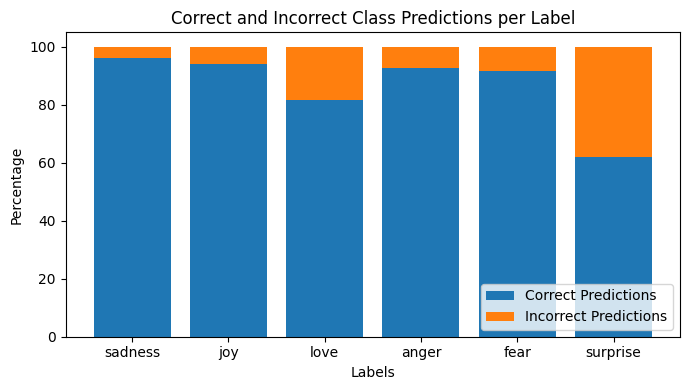

In [31]:
# creating a graph showing how well distilbert classified different classes
preds = np.argmax(test_predictions.predictions, axis=1)
lbls = test_predictions.label_ids

correct_per_class = np.zeros(6)
incorrect_per_class = np.zeros(6)

for i in range(len(lbls)):
    true_label = lbls[i]
    predicted_label = preds[i]
    if true_label == predicted_label:
        correct_per_class[true_label] += 1
    else:
        incorrect_per_class[true_label] += 1

total_per_class = correct_per_class + incorrect_per_class
correct_percentages = (correct_per_class / total_per_class) * 100
incorrect_percentages = (incorrect_per_class / total_per_class) * 100

plt.figure(figsize=(7, 4))
x = range(len(idx2lbl))
plt.bar(x, correct_percentages, label='Correct Predictions')
plt.bar(x, incorrect_percentages, bottom=correct_percentages, label='Incorrect Predictions')

plt.xlabel('Labels')
plt.ylabel('Percentage')
plt.title('Correct and Incorrect Class Predictions per Label')
plt.xticks(x, idx2lbl.values())
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [33]:
# load the new dataset - scraped and clean

In [34]:
from google.colab import files
uploaded = files.upload()

Saving clean_reddit_comments.csv to clean_reddit_comments.csv


In [35]:
# checking the new dataset from reddit
reddit_comments = pd.read_csv('clean_reddit_comments.csv', engine='python')
print(reddit_comments.head())

  Unnamed: 0                                         Post title  \
0          0  spain to legalise about  undocumented immigran...   
1          1  spain to legalise about  undocumented immigran...   
2          2  spain to legalise about  undocumented immigran...   
3          3  spain to legalise about  undocumented immigran...   
4          4  spain to legalise about  undocumented immigran...   

                                             Comment  
0  almost  unemployment rate and they need almost...  
1    great incentive to illegally immigrate to spain  
2  will this help to solve or increase the housin...  
3  madrid nov  reuters  spain will legalise about...  
4  uh is this wise the article said the reason is...  


In [36]:
# run baseline on the new dataset

In [37]:
# turned out some comments - rows are empty
print(reddit_comments['Comment'].isnull().sum())

3


In [38]:
# removing the empty rows
reddit_comments = reddit_comments.dropna(subset=['Comment'])

In [39]:
# setting a vectorizer for lr model for the new data and running the pre-trained model on it
X_test_logreg = vectorizer.transform(reddit_comments['Comment'])
predictions = model_lr.predict(X_test_logreg)

In [40]:
# helper emotion to label mapping
emotion_mapping = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

In [41]:
# adding a column with the lr model predictions
reddit_comments["LogReg_Emotion"] = [emotion_mapping[pred] for pred in predictions]

In [42]:
# checking the predictions
print(reddit_comments["LogReg_Emotion"])

0            joy
1            joy
2            joy
3            joy
4            joy
          ...   
31275        joy
31276    sadness
31277        joy
31278        joy
31279        joy
Name: LogReg_Emotion, Length: 31277, dtype: object


In [43]:
# run transformer on the comments

In [44]:
# running the fine-tuned distilbert model on new data
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
distilbert_model = AutoModelForSequenceClassification.from_pretrained('./logs/run1/')

distilbert_classifier = pipeline("text-classification", model=distilbert_model, tokenizer=tokenizer)

# adding a new column with the distilbert predictions
reddit_comments['DistilBERT_Emotion'] = reddit_comments['Comment'].apply(
    lambda x: distilbert_classifier(x)[0]['label']
)

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [45]:
# compare results on a graph

In [46]:
emotion_categories = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

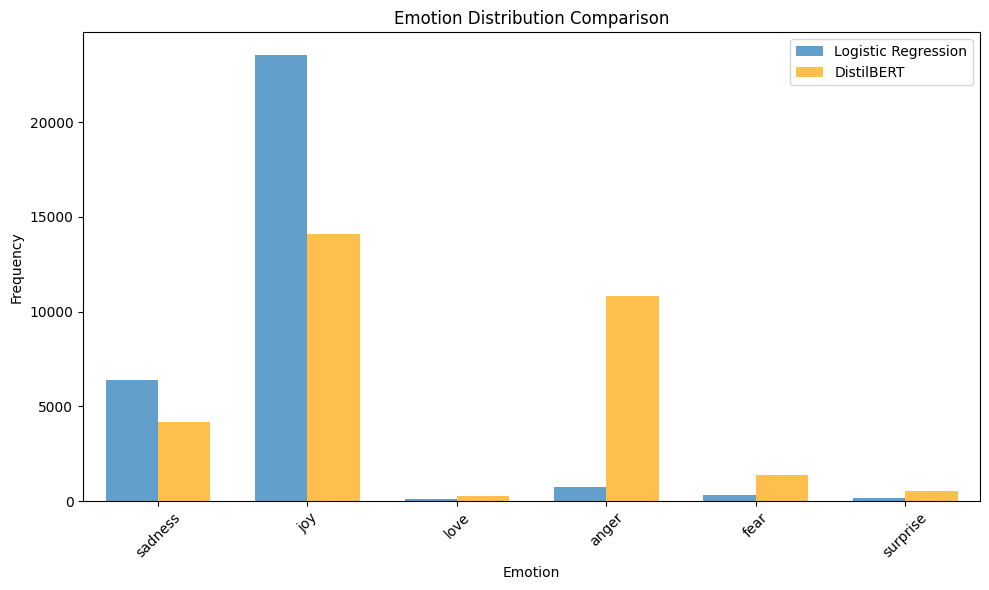

In [47]:
# creating a graph to compare how many instances per class the predictions were
logreg_counts = [reddit_comments['LogReg_Emotion'].str.count(emotion).sum() for emotion in emotion_categories]
distilbert_counts = [reddit_comments['DistilBERT_Emotion'].str.count(emotion).sum() for emotion in emotion_categories]

x = np.arange(len(emotion_categories))

fig, ax = plt.subplots(figsize=(10, 6))
reddit_comments['LogReg_Emotion']
bar_width = 0.35

ax.bar(x - bar_width / 2, logreg_counts, width=bar_width, alpha=0.7, label='Logistic Regression')
ax.bar(x + bar_width / 2, distilbert_counts, width=bar_width, alpha=0.7, color='orange', label='DistilBERT')

ax.set_xlim(-0.5, len(emotion_categories) - 0.5)

ax.set_title('Emotion Distribution Comparison')
ax.set_xlabel('Emotion')
ax.set_ylabel('Frequency')
ax.set_xticks(x)
ax.set_xticklabels(emotion_categories, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

In [48]:
# saving the predictions - the file with two new columns
reddit_comments.to_csv('predictions_rcomments.csv')

In [49]:
# checking what was the initial distribution of classes in the training data
# label counts
df_emotion_tr = pd.DataFrame(emotions['train']['labels'])

In [50]:
label_counts = df_emotion_tr.value_counts(normalize=True).sort_index()

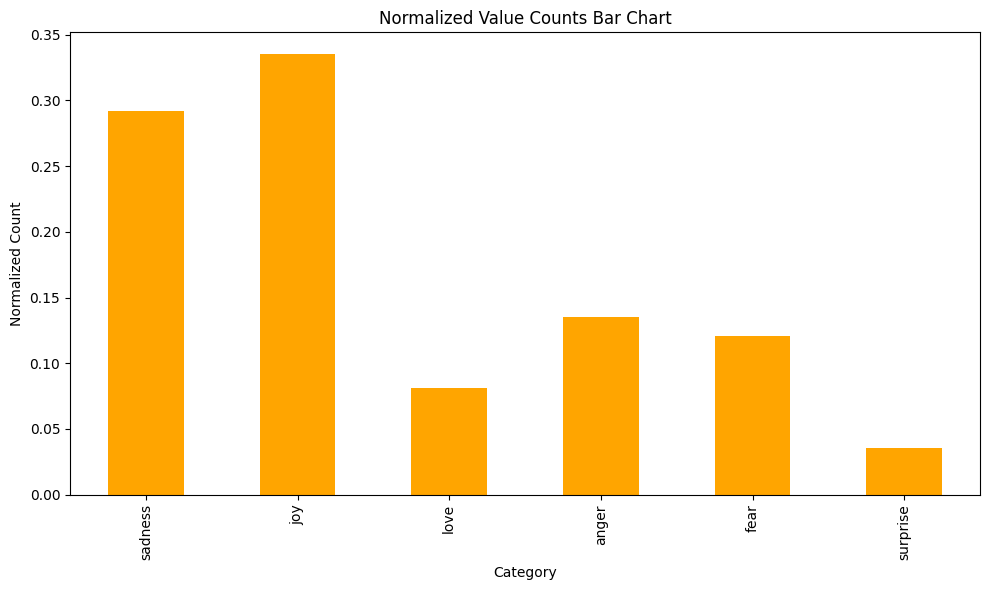

In [51]:
# creating a graph
label_counts.plot(kind='bar', figsize=(10, 6), color='orange')
plt.xlabel('Category')
plt.ylabel('Normalized Count')
plt.title('Normalized Value Counts Bar Chart')
plt.xticks(ticks=range(len(emotion_categories)), labels=emotion_categories)
plt.tight_layout()
plt.show()

In [52]:
# calculate agreement

In [53]:
# calculating how many of the predictions were the same for both models
agreement= (reddit_comments['DistilBERT_Emotion'] == reddit_comments['LogReg_Emotion']).sum()

# how many out of the total samples
total_samples = len(reddit_comments['DistilBERT_Emotion'])
agreement_rate = agreement / total_samples * 100
print(f"Prediction Agreement Rate: {agreement_rate:.3f}%")

Prediction Agreement Rate: 47.383%


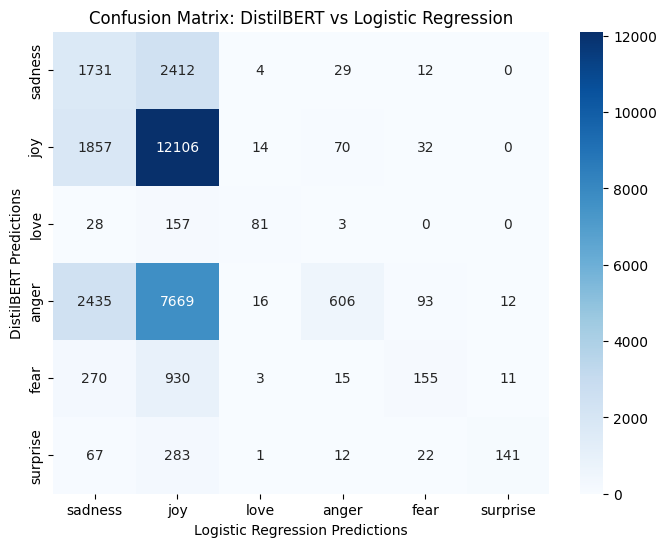

In [54]:
# creating a confusion matrix to analyse the differences and similarities in predictions on reddit data
conf_matrix = confusion_matrix(reddit_comments['DistilBERT_Emotion'],reddit_comments['LogReg_Emotion'],labels=emotion_categories)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["sadness","joy", "love", "anger","fear", "surprise"],
            yticklabels=["sadness","joy", "love", "anger","fear", "surprise"])
plt.xlabel("Logistic Regression Predictions")
plt.ylabel("DistilBERT Predictions")
plt.title("Confusion Matrix: DistilBERT vs Logistic Regression")
plt.show()